In [1]:
import numpy as np
import jax.experimental
from jax import jit, random, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from jax.config import config
from gnn_testbed.event_generation.photon_mc import calc_intersections, sph_to_cart, cherenkov_ang_dist
config.update("jax_debug_nans", False)
plt.rcParams["figure.dpi"] = 100


2021-09-16 08:04:56.875289: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.1'; dlerror: libcupti.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64


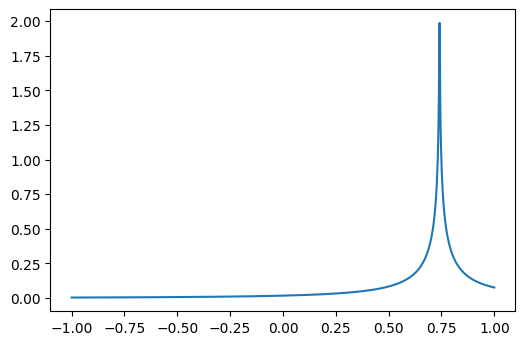

In [2]:
ct = jnp.linspace(-1, 1, 1000)
plt.plot(ct, cherenkov_ang_dist(ct))
a = 4.27033
d = -0.00103
maxval = a - d

In [3]:
fp = np.memmap("photons.dat", dtype="float32", mode="r", shape=(int(1e7), 15, 4))
fpd = np.memmap("photon_dirs.dat", dtype="float32", mode="r", shape=(int(1e7), 3))

In [4]:
theta = np.arccos(1/1.35)
costheta = np.cos(theta)
r = 10

target_x = sph_to_cart(theta, r)
target_r = 0.3

all_t = []
all_w = []

key = random.PRNGKey(0)

nph = int(1E6)
for i in range(10):
    key, subkey = random.split(key)
    isec_times, isec, weights = calc_intersections(fp[nph*i:(i+1)*nph, :, :3], fp[nph*i:(i+1)*nph, :, 3], target_x, target_r, 30, 100 / 90)
    tph = jnp.arccos(fpd[nph*i:(i+1)*nph, 2][jnp.any(isec, axis=1)])
    c_weight = cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval
    all_t.append(isec_times)
    all_w.append(weights*c_weight)
all_t = np.concatenate(all_t)
all_w = np.concatenate(all_w)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


[]

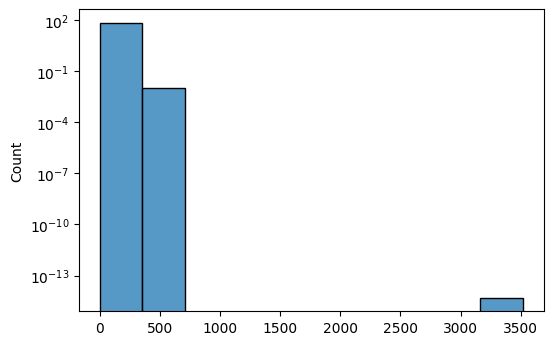

In [5]:
sns.histplot(x=all_t, weights=all_w)
plt.semilogy()

(10, 15)


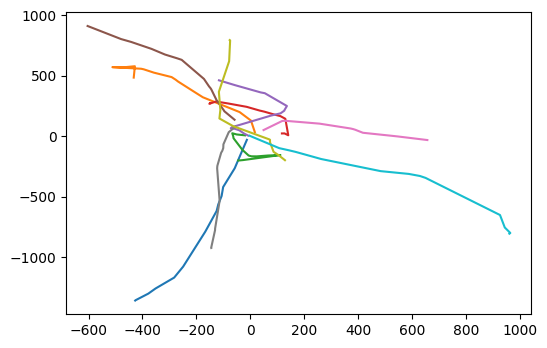

In [55]:
c_medium = 0.3 / 1.35
abs_len = 30
cnt= 10
weights = c_medium * jnp.cumsum(fp[:cnt, :, 3], axis=1) / abs_len 
print(weights.shape)
tph = jnp.arccos(fpd[:cnt, 2])[:, np.newaxis]
weights += jnp.log(cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval)
plt.plot(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, )#color="k", alpha=0.3);
#plt.scatter(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, s=10, c=weights)

In [41]:
weights

DeviceArray([[1.56359270e-03, 8.22196063e-03, 2.00255346e-02, ...,
              4.41593230e-01, 5.06838322e-01, 5.72282612e-01],
             [7.41667524e-02, 4.49892193e-01, 9.93589997e-01, ...,
              9.73245049e+00, 1.09010391e+01, 1.21415501e+01],
             [3.92781764e-01, 1.52259445e+00, 2.67169333e+00, ...,
              5.65068169e+01, 6.61603012e+01, 7.60157776e+01],
             ...,
             [3.52552459e-02, 2.08424270e-01, 5.51545143e-01, ...,
              1.09529743e+01, 1.29722805e+01, 1.49930649e+01],
             [1.21581249e-01, 2.84927815e-01, 4.49799180e-01, ...,
              3.47459435e+00, 3.89629364e+00, 4.31951427e+00],
             [8.24529156e-02, 1.89396158e-01, 6.21439517e-01, ...,
              9.45266533e+00, 1.06455526e+01, 1.19224834e+01]],            dtype=float32)